## import

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from joblib import dump, load
from scipy.stats import randint, uniform

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

## Load Data

In [5]:
df = pd.read_csv('../data/train.csv')

## Feature Selection

In [6]:
X = df.iloc[:,1:-1]
y = df.iloc[:,-1]

## Training set / Validation set / Test set

In [7]:
# 데이터를 70% 훈련 세트, 30% 임시 세트로 나누기
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# 임시 세트를 다시 50%로 나누어 15% 검증 세트, 15% 테스트 세트로 나누기
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## CatBoost

- 모델 정의

In [29]:
cat_features_indices = [1, 2, 3, 4, 5, 6]  # category 변수 인덱스
model_cat = CatBoostClassifier(loss_function='Logloss', eval_metric='Accuracy', cat_features=cat_features_indices, verbose=1)

- RandomizedSearchCV

In [30]:
# 파라미터 분포 설정
param_dist = {
    'n_estimators': randint(100, 300),
    'depth': randint(1, 5),
    'learning_rate': uniform(1e-3, 0.1),
    'min_child_samples': randint(10, 40),
    'grow_policy': ['SymmetricTree', 'Lossguide', 'Depthwise']
}

# RandomizedSearchCV 수행
random_search = RandomizedSearchCV(estimator=model_cat, param_distributions=param_dist, 
                                   n_iter=50, scoring='accuracy', cv=3, verbose=1, random_state=42)
random_search.fit(X_train, y_train)
random_search.fit(X, y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
0:	learn: 0.7100955	total: 42ms	remaining: 12s
1:	learn: 0.7113641	total: 66.5ms	remaining: 9.51s
2:	learn: 0.7114326	total: 86.1ms	remaining: 8.18s
3:	learn: 0.7117584	total: 107ms	remaining: 7.58s
4:	learn: 0.7504157	total: 127ms	remaining: 7.16s
5:	learn: 0.7522157	total: 146ms	remaining: 6.86s
6:	learn: 0.7505357	total: 166ms	remaining: 6.64s
7:	learn: 0.7471243	total: 184ms	remaining: 6.44s
8:	learn: 0.7513072	total: 203ms	remaining: 6.3s
9:	learn: 0.7478100	total: 224ms	remaining: 6.21s
10:	learn: 0.7505871	total: 244ms	remaining: 6.14s
11:	learn: 0.7507243	total: 266ms	remaining: 6.11s
12:	learn: 0.7517357	total: 284ms	remaining: 6.01s
13:	learn: 0.7674558	total: 303ms	remaining: 5.93s
14:	learn: 0.7785816	total: 324ms	remaining: 5.89s
15:	learn: 0.7872902	total: 343ms	remaining: 5.83s
16:	learn: 0.7867416	total: 363ms	remaining: 5.78s
17:	learn: 0.7846159	total: 381ms	remaining: 5.72s
18:	learn: 0.7846159	total: 401m

RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x00000191BEC9D180>,
                   n_iter=50,
                   param_distributions={'depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000191C33A9AE0>,
                                        'grow_policy': ['SymmetricTree',
                                                        'Lossguide',
                                                        'Depthwise'],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000191C33AA3E0>,
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000191C33A9E40>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000191BE9FBF40>},
                   random_state=42, scoring='accuracy', verbose=1)

- 최적의 모델 저장

In [31]:
best_model = random_search.best_estimator_
dump(best_model, 'catboost_best_model.joblib')

['catboost_best_model.joblib']

- 테스트 세트 평가

In [8]:
loaded_model = load('catboost_best_model.joblib')

y_pred = loaded_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"테스트 데이터 정확도: {accuracy}")

테스트 데이터 정확도: 0.8565333333333334


- 성능 평가

In [9]:
y_pred_prob = loaded_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("AUC: {:.4f}".format(roc_auc))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

AUC: 0.9466
Precision: 0.8584
Recall: 0.8625
F1 Score: 0.8605

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      9132
           1       0.86      0.86      0.86      9618

    accuracy                           0.86     18750
   macro avg       0.86      0.86      0.86     18750
weighted avg       0.86      0.86      0.86     18750



- Confusion Matrix 시각화

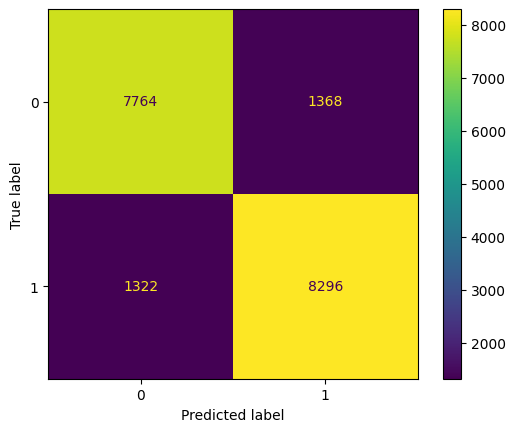

In [10]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

- ROC Curve 시각화

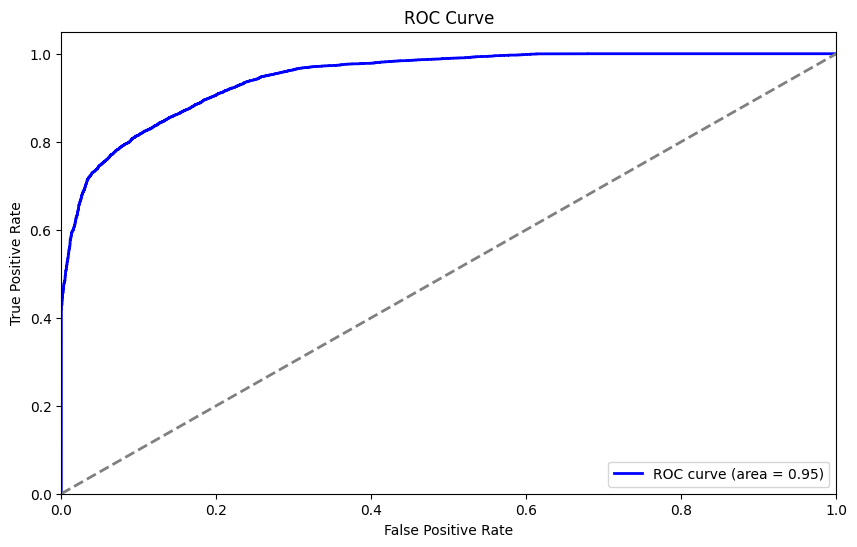

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()